# Convolution Neural Networks with TensorFlow

In [1]:
%matplotlib inline

In [2]:
import os,sys

In [3]:
sys.path.append( os.getcwd() + '/ML' )

In [4]:
import numpy
import numpy as np

In [5]:
import tensorflow
import tensorflow as tf

## MNIST Data  

cf. Found here http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz or https://www-labs.iro.umontreal.ca/~lisa/deep/data/mnist/?C=M;O=A

In [6]:
import gzip
import six.moves.cPickle as pickle 

In [7]:
# find where `mnist.pkl.gz` is on your own computer 
f=gzip.open("../Data/mnist.pkl.gz",'rb')
try:
    train_set,valid_set,test_set = pickle.load(f,encoding='latin1')
except:
    train_set,valid_set,test_set = pickle.load(f)
f.close()

In [8]:
train_set_x,train_set_y=train_set
valid_set_x,valid_set_y=valid_set
test_set_x,test_set_y=test_set
train_set_x = train_set_x.astype(np.float32)
train_set_y = train_set_y.astype(np.float32)
valid_set_x = valid_set_x.astype(np.float32)
valid_set_y = valid_set_y.astype(np.float32)
test_set_x = test_set_x.astype(np.float32)
test_set_y = test_set_y.astype(np.float32)
print(train_set_x.shape,train_set_y.shape) # observe the value for (m,d), number of training examples x number of features
print(valid_set_x.shape,valid_set_y.shape)
print(test_set_x.shape,test_set_y.shape)

((50000, 784), (50000,))
((10000, 784), (10000,))
((10000, 784), (10000,))


In [23]:
# this is for reshaping the MNIST data into something for convolution neural networks
train_set_x = train_set_x.reshape((train_set_x.shape[0],28,28,1))
valid_set_x = valid_set_x.reshape((valid_set_x.shape[0],28,28,1))
test_set_x = test_set_x.reshape((test_set_x.shape[0],28,28,1))
print(train_set_x.shape)
print(valid_set_x.shape)
print(test_set_x.shape)

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


In [10]:
print(train_set_y.min())
print(train_set_y.max())
print(valid_set_y.min())
print(valid_set_y.max())
print(test_set_y.min())
print(test_set_y.max())

0.0
9.0
0.0
9.0
0.0
9.0


Turn this into a so-called "one-hot vector representation."  

Recall that whereas the original labels (in the variable y) were 0,1, ..., 9 for 10 different (single) digits, for the purpose of training a neural network, we need to recode these labels as vectors containing only values 0 or 1.  

In [11]:
K=10  
m_train = train_set_y.shape[0]
m_valid = valid_set_y.shape[0]
m_test  = test_set_y.shape[0]
y_train = [np.zeros(K) for row in train_set_y] # list of m_train numpy arrays of size dims. (10,)
y_valid = [np.zeros(K) for row in valid_set_y] # list of m_valid numpy arrays of size dims. (10,)
y_test = [np.zeros(K) for row in test_set_y] # list of m_test numpy arrays of size dims. (10,)
for i in range(m_train):
    y_train[i][ int(train_set_y[i]) ] = 1.
for i in range(m_valid):
    y_valid[i][ int(valid_set_y[i]) ] = 1.
for i in range(m_test):
    y_test[i][ int(test_set_y[i]) ] = 1.
y_train = np.array(y_train).astype(np.float32)
y_valid = np.array(y_valid).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)   
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)
(10000, 10)


In [12]:
print(y_train.min())
print(y_train.max())
print(y_valid.min())
print(y_valid.max())
print(y_test.min())
print(y_test.max())

0.0
1.0
0.0
1.0
0.0
1.0


# Convolution operator $*$ and related filter (stencil) $c$ example

In [13]:
X = tf.placeholder(tf.float32, shape=[None,None,None,3],name="X")

filter_size = (9,9,3,2)  # (W_1,W_2,C_lm1,C_l)
c_bound = np.sqrt(3*9*9)
c = tf.Variable( tf.random_uniform(filter_size,
                                    minval=-1.0/c_bound,
                                      maxval=1.0/c_bound))

b=tf.Variable(tf.random_uniform([2,],minval=-.5,maxval=.5), dtype=tf.float32)

In [50]:
print(c.shape)
print(b.shape)

(9, 9, 3, 2)
(2,)


In [71]:
conv_out=tf.nn.conv2d(X,
                     c,
                     strides=[1,1,1,1],
                     padding="VALID",
                     use_cudnn_on_gpu=True,name=None)

In [54]:
zl = tf.nn.sigmoid( conv_out + b )

Let's have a little bit of fun with this:

In [55]:
import pylab
from PIL import Image

In [56]:
# open example image of dimensions 639x516, HxW  
img = Image.open(open('../Data/3wolfmoon.jpg'))
print(img.size)  # WxH
print(np.asarray(img).max())
print(np.asarray(img).min())

(516, 639)
255
0


In [58]:
# dimensions are (height,width,channel)
img_np=np.asarray(img,dtype=np.float32)/256.
print(img_np.shape)
print(img_np.max())
print(img_np.min())

(639, 516, 3)
0.996094
0.0


In [59]:
# put image in 4D tensor of shape (1,height,width,3)
img_ = img_np.reshape(1,639,516,3)
print(img_.shape)
print(img_.max())
print(img_.min())

(1, 639, 516, 3)
0.996094
0.0


In [62]:
sess = tf.Session()
init_op=tf.global_variables_initializer()
sess.run(init_op)            

In [63]:
filtered_img = sess.run(zl,feed_dict={X:img_})

In [65]:
print(type(filtered_img))
print(filtered_img.shape)

<type 'numpy.ndarray'>
(1, 631, 508, 2)


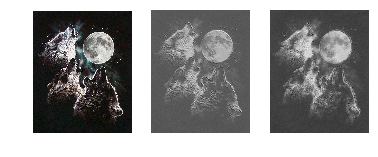

In [68]:
# plot original image and first and second components of output
pylab.subplot(1, 3, 1); pylab.axis('off'); pylab.imshow(img)
pylab.gray();
# recall that the convOp output (filtered image) is actually a "minibatch",
# of size 1 here, so we take index 0 in the first dimension:
pylab.subplot(1, 3, 2); pylab.axis('off'); pylab.imshow(filtered_img[0, :, :,0])
pylab.subplot(1, 3, 3); pylab.axis('off'); pylab.imshow(filtered_img[0, :, :,1])
pylab.show()

In [72]:
print(type(img_))
print(img_.shape)
print(img_.max())
print(img_.min())
print(type(filtered_img))
print(filtered_img.shape)
print(filtered_img.max())
print(filtered_img.min())

<type 'numpy.ndarray'>
(1, 639, 516, 3)
0.996094
0.0
<type 'numpy.ndarray'>
(1, 631, 508, 2)
0.792409
0.417905


Empirically, we seen that the image "shrank" in size dimensions.  We can infer that this convolution operation doesn't assume anything about the boundary conditions, and so the filter (stencil), requiring a, in this case, 9x9 "block" or 9x9 values, will only, near the boundaries, output values for the "inside" cells/grid points.  

# MaxPooling

In [76]:
input = tf.placeholder(tf.float32, shape=[None,None,None,None],name="input")
maxpool_shape=(2,2)
window_size = (1,) + maxpool_shape + (1,)
pool_out = tf.nn.max_pool(input,
                            ksize=window_size,
                              strides=window_size,padding="VALID")

In [84]:
tf.reset_default_graph() 

In [77]:
sess = tf.Session()
init_op=tf.global_variables_initializer()
sess.run(init_op)  

In [79]:
invals=np.random.RandomState(1).rand(3,5,5,2)
print(invals.shape)
invals_max = sess.run(pool_out,feed_dict={input:invals})
print(invals_max.shape)

(3, 5, 5, 2)
(3, 2, 2, 2)


In [80]:
invals2 = np.random.RandomState(1).rand(3,256,64,2)
print(invals2.shape)
invals2_max = sess.run(pool_out,feed_dict={input:invals2})
print(invals2_max.shape)
invals3 = np.random.RandomState(1).rand(3,257,65,2)
print(invals3.shape)
invals3_max = sess.run(pool_out,feed_dict={input:invals3})
print(invals3_max.shape)


(3, 256, 64, 2)
(3, 128, 32, 2)
(3, 257, 65, 2)
(3, 128, 32, 2)


In [88]:
tf.reset_default_graph() 

In [89]:
input = tf.placeholder(tf.float32, shape=[None,None,None,None],name="input")
maxpool_shape2=(4,4)
window_size2 = (1,) + maxpool_shape2 + (1,)
pool_out2 = tf.nn.max_pool(input,
                            ksize=window_size2,
                              strides=window_size2,padding="VALID")

In [90]:
sess = tf.Session()
init_op=tf.global_variables_initializer()
sess.run(init_op)  

In [91]:
invals2_max = sess.run(pool_out2,feed_dict={input:invals2})
print(invals2_max.shape)

(3, 64, 16, 2)


# Convolution axon test

In [12]:
sys.path.append( "../ML/")

In [13]:
import CNN_tf
from CNN_tf import Axon_CNN

In [116]:
tf.reset_default_graph() 

In [117]:
filter_size = (9,9,3,2)  # (W_1,W_2,C_lm1,C_l)
c_bound = np.sqrt(3*9*9)
c = tf.Variable( tf.random_uniform(filter_size,
                                    minval=-1.0/c_bound,
                                      maxval=1.0/c_bound))

b=tf.Variable(tf.random_uniform([2,],minval=-.5,maxval=.5), dtype=tf.float32)

In [118]:
Conv_axon_test=Axon_CNN(1,(3,2),(9,9),Pl=None,c=c,b=b,activation=None)

In [119]:
Conv_axon_test.connect_through()

<tf.Tensor 'add_1:0' shape=(?, ?, ?, 2) dtype=float32>

In [120]:
sess = tf.Session()
init_op=tf.global_variables_initializer()
sess.run(init_op)  

In [121]:
filtered_img_Conv_axon_test = sess.run(Conv_axon_test.al,feed_dict={Conv_axon_test.alm1:img_})

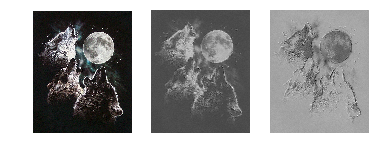

In [122]:
# plot original image and first and second components of output
pylab.subplot(1, 3, 1); pylab.axis('off'); pylab.imshow(img)
pylab.gray();
# recall that the convOp output (filtered image) is actually a "minibatch",
# of size 1 here, so we take index 0 in the first dimension:
pylab.subplot(1, 3, 2); pylab.axis('off'); pylab.imshow(filtered_img_Conv_axon_test[0, :, :,0])
pylab.subplot(1, 3, 3); pylab.axis('off'); pylab.imshow(filtered_img_Conv_axon_test[0, :, :,1])
pylab.show()

In [123]:
print(type(img_))
print(img_.shape)
print(img_.max())
print(img_.min())
print(type(filtered_img_Conv_axon_test))
print(filtered_img_Conv_axon_test.shape)
print(filtered_img_Conv_axon_test.max())
print(filtered_img_Conv_axon_test.min())

<type 'numpy.ndarray'>
(1, 639, 516, 3)
0.996094
0.0
<type 'numpy.ndarray'>
(1, 631, 508, 2)
0.766957
-1.11119


In [8]:
rand_unif_init_vals *= np.float32(4)

In [10]:
(1,) + (2,2) + (1,)

(1, 2, 2, 1)

In [11]:
[1,] + [2,2] + [1,]

[1, 2, 2, 1]

In [12]:
[1,] + (2,2) + [1,]

TypeError: can only concatenate list (not "tuple") to list

In [13]:
list( [1,2,3])

[1, 2, 3]

In [14]:
testplacehold = tf.placeholder(tf.float32, shape=[None, 100,100,2])

In [16]:
testplacehold.shape

TensorShape([Dimension(None), Dimension(100), Dimension(100), Dimension(2)])

In [27]:
tf.reshape( testplacehold, shape=[-1,int( testplacehold.shape[1]*testplacehold.shape[2]*testplacehold.shape[3])]).shape

TensorShape([Dimension(None), Dimension(20000)])

In [28]:
len(testplacehold.shape)

4

# CNN Feedforward test for Convolution Neural Networks

In [34]:
# sanity check
CNNFF_test = CNN_tf.Feedforward(2,('C','C'),
                             [{"C_ls":(1,20) ,"Wl":(5,5),"Pl":(2,2),"Ll":(28,28)},
                             {"C_ls":(20,50),"Wl":(5,5),"Pl":(2,2),"Ll":(12,12)}],
                             psi_L=tf.tanh )

In [35]:
s_l = (50*4*4,500)
tf.reshape( CNNFF_test.Axons[-1].al, shape=[-1,s_l[0] ]).shape

TensorShape([Dimension(None), Dimension(800)])

In [17]:
# sanity check
CNNFF_test = CNN_tf.Feedforward(3,('C','C','D'),
                             [{"C_ls":(1,20) ,"Wl":(5,5),"Pl":(2,2),"Ll":(28,28)},
                             {"C_ls":(20,50),"Wl":(5,5),"Pl":(2,2),"Ll":(12,12)},
                             (50*4*4,500)],
                             psi_L=tf.tanh )

## CNN class test as a Deep Neural Network (i.e. Artificial neural network, i.e. no convolution)

In [14]:
L=4
CorD=('D','D','D','D')
dims_data_test=[(784,392), (392,196),(196,98),(98,10)]

In [15]:
CNNFF_test=CNN_tf.Feedforward(L,CorD,dims_data_test,psi_L=tf.nn.softmax)

In [16]:
CNN_test=CNN_tf.CNN(CNNFF_test)

In [17]:
CNN_test.connect_through()

<tf.Tensor 'Softmax_1:0' shape=(?, 10) dtype=float32>

In [18]:
CNN_test.build_J_L2norm_w_reg(lambda_val=0.01)

<tf.Tensor 'add:0' shape=() dtype=float32>

In [19]:
CNN_test.build_optimizer()

<tf.Operation 'GradientDescent' type=NoOp>

In [22]:
CNN_test.train_model(max_iters=10000, X_data=train_set_x[:20000],y_data=y_train[:20000])

Found self._sess: 

Found self._saver: 

Found self._init_op, executing sess.run(init_op) now: 

Iter :   0, J,cost,i.e. error-train: 5.2155 
Iter :   1, J,cost,i.e. error-train: 5.1928 
Iter :   2, J,cost,i.e. error-train: 5.1761 
Iter :   3, J,cost,i.e. error-train: 5.1641 
Iter :   4, J,cost,i.e. error-train: 5.1556 
Iter :   5, J,cost,i.e. error-train: 5.1494 
Iter :   6, J,cost,i.e. error-train: 5.1448 
Iter :   7, J,cost,i.e. error-train: 5.1413 
Iter :   8, J,cost,i.e. error-train: 5.1386 
Iter :   9, J,cost,i.e. error-train: 5.1364 
Iter : 1000, J,cost,i.e. error-train: 4.9854 
Iter : 2000, J,cost,i.e. error-train: 4.8989 
Iter : 3000, J,cost,i.e. error-train: 4.8675 
Iter : 4000, J,cost,i.e. error-train: 4.8630 
Iter : 5000, J,cost,i.e. error-train: 4.8670 
Iter : 6000, J,cost,i.e. error-train: 4.8728 
Iter : 7000, J,cost,i.e. error-train: 4.8788 
Iter : 8000, J,cost,i.e. error-train: 4.8848 
Iter : 9000, J,cost,i.e. error-train: 4.8906 
Final error: 4.8962068557739257812


array([ 5.21552753,  5.19278383,  5.17607212, ...,  4.89619493,
        4.89620113,  4.89620686])

In [24]:
yhat_test = CNN_test.predict()

Found self._sess: 



In [30]:
print(type(yhat_test))
print(yhat_test.shape)
print(np.argmax(yhat_test,axis=1).shape)
np.mean( train_set_y[:20000]==np.argmax(yhat_test,axis=1) )

<type 'numpy.ndarray'>
(20000, 10)
(20000,)


0.92225000000000001

# CNN class test for Convolution Neural Networks 

In [13]:
sys.path.append( "../ML/")

In [14]:
import CNN_tf
from CNN_tf import Axon_CNN

In [15]:
L=4
CorD=('C','C','D','D')
dims_data_test=[{"C_ls":(1,20) ,"Wl":(5,5),"Pl":(2,2),"Ll":(28,28)},
               {"C_ls":(20,50) ,"Wl":(5,5),"Pl":(2,2),"Ll":(12,12)},
               (50*4*4,500),(500,10)] 
CNNFF_test = CNN_tf.Feedforward(L,CorD,dims_data_test,psi_L=tf.nn.softmax)

In [16]:
CNN_test = CNN_tf.CNN(CNNFF_test)

In [17]:
CNN_test.connect_through()

<tf.Tensor 'Softmax_1:0' shape=(?, 10) dtype=float32>

In [18]:
CNN_test.build_J_logistic_w_reg(lambda_val=0.01)

<tf.Tensor 'add_6:0' shape=() dtype=float32>

In [19]:
CNN_test.build_optimizer(alpha=0.005)

<tf.Operation 'GradientDescent' type=NoOp>

In [24]:
CNN_test.train_model(max_iters=10, X_data=train_set_x[:30000],y_data=y_train[:30000])

Found self._sess: 

Found self._saver: 

Found self._init_op, executing sess.run(init_op) now: 

Iter :   0, J,cost,i.e. error-train: 7.6116 
Iter :   1, J,cost,i.e. error-train: 7.0324 
Iter :   2, J,cost,i.e. error-train: 6.8482 
Iter :   3, J,cost,i.e. error-train: 6.7898 
Iter :   4, J,cost,i.e. error-train: 6.7644 
Iter :   5, J,cost,i.e. error-train: 6.7518 
Iter :   6, J,cost,i.e. error-train: 6.7447 
Iter :   7, J,cost,i.e. error-train: 6.7395 
Iter :   8, J,cost,i.e. error-train: 6.7350 
Iter :   9, J,cost,i.e. error-train: 6.7305 
Final error: 6.7304854393005371094


array([ 7.61161232,  7.03240919,  6.84823608,  6.7897892 ,  6.76444244,
        6.75178337,  6.74467087,  6.73954916,  6.73495483,  6.73048544])

In [22]:
CNN_test._CNN_model.Axons[0].alm1


<tf.Tensor 'X:0' shape=(?, 28, 28, 1) dtype=float32>